In [1]:
##### some basic modules
import os
import numpy as np
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

##### Image-related modules
from skimage.color import rgb2lab, lab2rgb, rgb2gray, xyz2lab
import cv2 

##### keras module
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from keras.layers import Input
from keras.models import Model


Using TensorFlow backend.


In [2]:
##### Import custom function

from data_preprocessing import rgb_lab_transformation, feature_label_generation, data_generation
from visualization import visualize_validation_image
from GAN_model import GAN

## 1. Uploading and Preprocessing Dataset

##### Uploading

In [3]:
size_row = 128
size_col = 128

dir_name = '..' # name of directory where image data is located

In [4]:
train_image, test_image, train_label, test_label = data_generation(dir_name = dir_name,
                                                                   image_size = (size_row, size_col)) 
                                                                   # for training only one character, need to specify the character name

1/173
2/173
3/173
4/173
5/173
6/173
7/173
8/173
9/173
10/173
11/173
12/173
13/173
14/173
15/173
16/173
17/173
18/173
19/173
20/173
21/173
22/173
23/173
24/173
25/173
26/173
27/173
28/173
29/173
30/173
31/173
32/173
33/173
34/173
35/173
36/173
37/173
38/173
39/173
40/173
41/173
42/173
43/173
44/173
45/173
46/173
47/173
48/173
49/173
50/173
51/173
52/173
53/173
54/173
55/173
56/173
57/173
58/173
59/173
60/173
61/173
62/173
63/173
64/173
65/173
66/173
67/173
68/173
69/173
70/173
71/173
72/173
73/173
74/173
75/173
76/173
77/173
78/173
79/173
80/173
81/173
82/173
83/173
84/173
85/173
86/173
87/173
88/173
89/173
90/173
91/173
92/173
93/173
94/173
95/173
96/173
97/173
98/173
99/173
100/173
101/173
102/173
103/173
104/173
105/173
106/173
107/173
108/173
109/173
110/173
111/173
112/173
113/173
114/173
115/173
116/173
117/173
118/173
119/173
120/173
121/173
122/173
123/173
124/173
125/173
126/173
127/173
128/173
129/173
130/173
131/173
132/173
133/173
134/173
135/173
136/173
137/173
138/173
139/

In [5]:
train_feature = train_image.reshape(train_image.shape[0], size_row, size_col, 1) 
test_feature = test_image.reshape(test_image.shape[0], size_row, size_col, 1)

x_feature = np.concatenate([train_feature, test_feature])
x_label = np.concatenate([train_label, test_label])

## 2. Defining and Fitting the Model

##### Define the model

In [6]:
latent_dim = 1000

In [7]:
gan = GAN(input_shape = (size_row, size_col), latent_dim = latent_dim)

In [8]:
optimizer = Adam(0.0001, 0.5)

# Build and compile the discriminator
discriminator = gan.build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 33, 33, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 33, 33, 64)        256       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 33, 33, 64)        0         
__________

In [9]:
# Build the generator
generator = gan.build_generator()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
up_sampling2d_1 (UpSampling2 (None, 16, 16, 384)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 128)       442496    
_________________________________________________________________
batch_normalization_4 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
activation_1 (Activation)    (None, 16, 16, 128)       0         
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 64)        73792     
_________________________________________________________________
batch_normalization_5 (Batch (None, 32, 32, 64)        256       
__________

In [10]:
# The generator takes noise as input and generates imgs
z = Input(shape=(latent_dim,))
img_l_input = Input(shape=(size_row, size_col,1))

img_ab = generator([z, img_l_input])

# For the combined model we will only train the generator
discriminator.trainable = False

In [11]:
# The discriminator takes generated images as input and determines validity
valid = discriminator(img_ab)

In [12]:
# The combined model  (stacked generator and discriminator)
# Trains the generator to fool the discriminator
combined = Model([z, img_l_input], valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

##### Combine three gray image and conver to lab image

In [13]:
epochs = 5000
batch_size = 32

In [14]:
image_valid = plt.imread('directory') # insert name of directory where validation image is located
image_valid = cv2.resize(image_valid, (size_row, size_col))

img_gray = rgb2gray(image_valid).reshape(size_row, size_col, 1)
img_gray3 = np.concatenate([img_gray]*3, axis = 2) # concatenating three gray images so that it can have 3 channels
img_lab3 = rgb2lab(img_gray3) # convert concatenated image to lab

valid_input = img_lab3[:,:,0].reshape(1, size_row, size_col, 1)/128

##### Fitting

In [15]:
valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

In [16]:
g_losses = []
d_losses = []
img_colorized = []

for epoch in range(epochs):

    ##### Train Discriminator

    # Select a random half of images
    idx = np.random.randint(0, x_feature.shape[0], batch_size)
    imgs = x_feature[idx]
    label = x_label[idx] 
    
    # Sample noise and generate a batch of new images
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    gen_imgs = generator.predict([noise, imgs])

    # Train the discriminator (real classified as ones and generated as zeros)
    d_loss_real = discriminator.train_on_batch(np.concatenate([imgs,label], axis = -1), valid)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    ##### Train Generator

    # Train the generator (wants discriminator to mistake images as real)
    g_loss = combined.train_on_batch([noise, imgs], valid)
    g_losses.append(g_loss)
    d_losses.append(d_loss[0])
    
    ##### Visualize image

    if epoch % 250 == 0:
    
        print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
        zero_noise = np.zeros(latent_dim).reshape(1,latent_dim)
        gen_imgs = generator.predict([zero_noise, valid_input])
        image_indiv_ab = gen_imgs[0,:,:,1:].reshape(size_row, size_col,2)
        image_indiv = np.concatenate([img_lab3[:,:,:1]/128, image_indiv_ab], axis = 2)

        img_colorized.append(lab2rgb(image_indiv.astype('float64')*128))



/home/dabsdamoon/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 1.421272, acc.: 20.31%] [G loss: 0.571571]


/home/dabsdamoon/anaconda3/envs/tensorflow/lib/python3.6/site-packages/skimage/color/colorconv.py:993: UserWarning: Color data out of range: Z < 0 in 716 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


250 [D loss: 0.506148, acc.: 71.88%] [G loss: 1.119579]
500 [D loss: 0.293234, acc.: 85.94%] [G loss: 1.518167]


/home/dabsdamoon/anaconda3/envs/tensorflow/lib/python3.6/site-packages/skimage/color/colorconv.py:993: UserWarning: Color data out of range: Z < 0 in 75 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


750 [D loss: 0.531152, acc.: 71.88%] [G loss: 2.728544]


/home/dabsdamoon/anaconda3/envs/tensorflow/lib/python3.6/site-packages/skimage/color/colorconv.py:993: UserWarning: Color data out of range: Z < 0 in 233 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


1000 [D loss: 0.174610, acc.: 93.75%] [G loss: 3.480690]


/home/dabsdamoon/anaconda3/envs/tensorflow/lib/python3.6/site-packages/skimage/color/colorconv.py:993: UserWarning: Color data out of range: Z < 0 in 517 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


1250 [D loss: 0.391783, acc.: 84.38%] [G loss: 2.767483]


/home/dabsdamoon/anaconda3/envs/tensorflow/lib/python3.6/site-packages/skimage/color/colorconv.py:993: UserWarning: Color data out of range: Z < 0 in 958 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


1500 [D loss: 0.167506, acc.: 93.75%] [G loss: 4.027886]


/home/dabsdamoon/anaconda3/envs/tensorflow/lib/python3.6/site-packages/skimage/color/colorconv.py:993: UserWarning: Color data out of range: Z < 0 in 828 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


1750 [D loss: 0.090678, acc.: 98.44%] [G loss: 3.820746]


/home/dabsdamoon/anaconda3/envs/tensorflow/lib/python3.6/site-packages/skimage/color/colorconv.py:993: UserWarning: Color data out of range: Z < 0 in 581 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


2000 [D loss: 0.040721, acc.: 98.44%] [G loss: 2.900336]


/home/dabsdamoon/anaconda3/envs/tensorflow/lib/python3.6/site-packages/skimage/color/colorconv.py:993: UserWarning: Color data out of range: Z < 0 in 464 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


2250 [D loss: 0.042433, acc.: 100.00%] [G loss: 4.036509]


/home/dabsdamoon/anaconda3/envs/tensorflow/lib/python3.6/site-packages/skimage/color/colorconv.py:993: UserWarning: Color data out of range: Z < 0 in 327 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


2500 [D loss: 0.029611, acc.: 100.00%] [G loss: 4.610559]


/home/dabsdamoon/anaconda3/envs/tensorflow/lib/python3.6/site-packages/skimage/color/colorconv.py:993: UserWarning: Color data out of range: Z < 0 in 251 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


2750 [D loss: 0.142612, acc.: 93.75%] [G loss: 6.053175]


/home/dabsdamoon/anaconda3/envs/tensorflow/lib/python3.6/site-packages/skimage/color/colorconv.py:993: UserWarning: Color data out of range: Z < 0 in 36 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


3000 [D loss: 0.126722, acc.: 95.31%] [G loss: 6.915347]


/home/dabsdamoon/anaconda3/envs/tensorflow/lib/python3.6/site-packages/skimage/color/colorconv.py:993: UserWarning: Color data out of range: Z < 0 in 27 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


3250 [D loss: 0.051840, acc.: 98.44%] [G loss: 6.653625]


/home/dabsdamoon/anaconda3/envs/tensorflow/lib/python3.6/site-packages/skimage/color/colorconv.py:993: UserWarning: Color data out of range: Z < 0 in 11 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


3500 [D loss: 0.023492, acc.: 100.00%] [G loss: 4.828962]


/home/dabsdamoon/anaconda3/envs/tensorflow/lib/python3.6/site-packages/skimage/color/colorconv.py:993: UserWarning: Color data out of range: Z < 0 in 6 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


3750 [D loss: 0.013788, acc.: 100.00%] [G loss: 7.117147]


/home/dabsdamoon/anaconda3/envs/tensorflow/lib/python3.6/site-packages/skimage/color/colorconv.py:993: UserWarning: Color data out of range: Z < 0 in 1 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


4000 [D loss: 0.045231, acc.: 98.44%] [G loss: 6.956887]


/home/dabsdamoon/anaconda3/envs/tensorflow/lib/python3.6/site-packages/skimage/color/colorconv.py:993: UserWarning: Color data out of range: Z < 0 in 17 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


4250 [D loss: 0.158019, acc.: 93.75%] [G loss: 8.105566]
4500 [D loss: 0.006364, acc.: 100.00%] [G loss: 7.894997]
4750 [D loss: 0.035581, acc.: 98.44%] [G loss: 6.018426]


/home/dabsdamoon/anaconda3/envs/tensorflow/lib/python3.6/site-packages/skimage/color/colorconv.py:993: UserWarning: Color data out of range: Z < 0 in 15 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


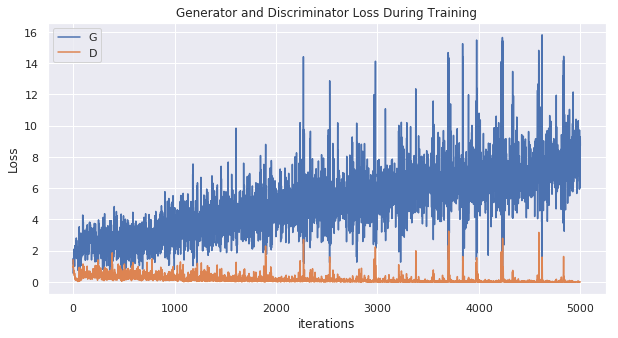

In [17]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(g_losses,label="G")
plt.plot(d_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

##### Visualization

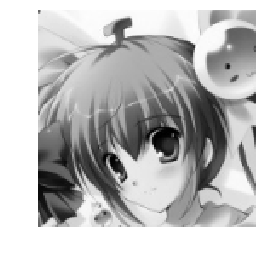

In [18]:
input_val = img_gray.copy()
plt.imshow(input_val.reshape(size_row, size_col), cmap = 'gray')
plt.axis('off')
plt.show()

In [19]:
grid_row = 4
grid_col = 5

In [20]:
g_row = []
i = 0

for r in range(grid_row):
    
    g_column = []
    
    for c in range(grid_col):
        g_column.append(img_colorized[i])
        i += 1
        
    g_column = np.concatenate(g_column, axis = 1)
    g_row.append(g_column)

g_row = np.concatenate(g_row)

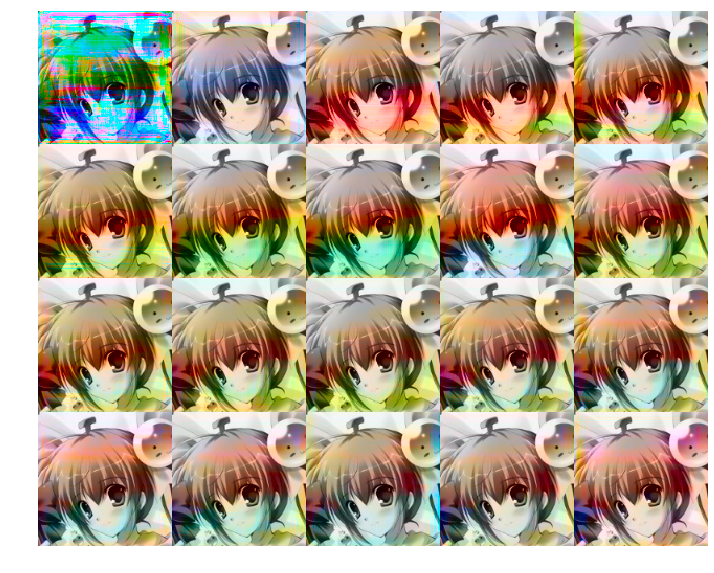

In [21]:
plt.figure(figsize = (12,12))
plt.axis('off')
plt.imshow(g_row)

##### Colorization using DIfferent Noise Values

In [22]:
def custom_noise(latent_dim = 1000, sequence_num = 5, interval = 5, interval_order = [-2,-1,0,1,2]):

    seq_length = int(latent_dim / sequence_num)

    noise_vec = []

    for s in range(sequence_num):

        for i in interval_order: # total length = sequence_num * len(interval_order)

            noise_original = np.zeros((1, latent_dim))
            noise_original[:, (s)*seq_length:(s+1)*seq_length] = noise_original[:, (s)*seq_length:(s+1)*seq_length] + interval*i

            noise_vec.append(noise_original)

    return np.concatenate(noise_vec, axis = 0)

In [23]:
gen_imgs = generator.predict([custom_noise(), np.concatenate([valid_input]*25, axis = 0)])

In [24]:
r, c = 5, 5

image_col = []
i = 0

for col_num in range(c):

    image_row = []

    for row_num in range(r):

        image_indiv_ab = gen_imgs[i,:,:,1:].reshape(size_row, size_col,2)
        image_indiv = np.concatenate([img_lab3[:,:,:1]/128, image_indiv_ab], axis = 2)
        image_row.append(image_indiv.astype('float64'))
        i += 1

    image_row = np.concatenate(image_row)
    image_col.append(image_row)

/home/dabsdamoon/anaconda3/envs/tensorflow/lib/python3.6/site-packages/skimage/color/colorconv.py:993: UserWarning: Color data out of range: Z < 0 in 436 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


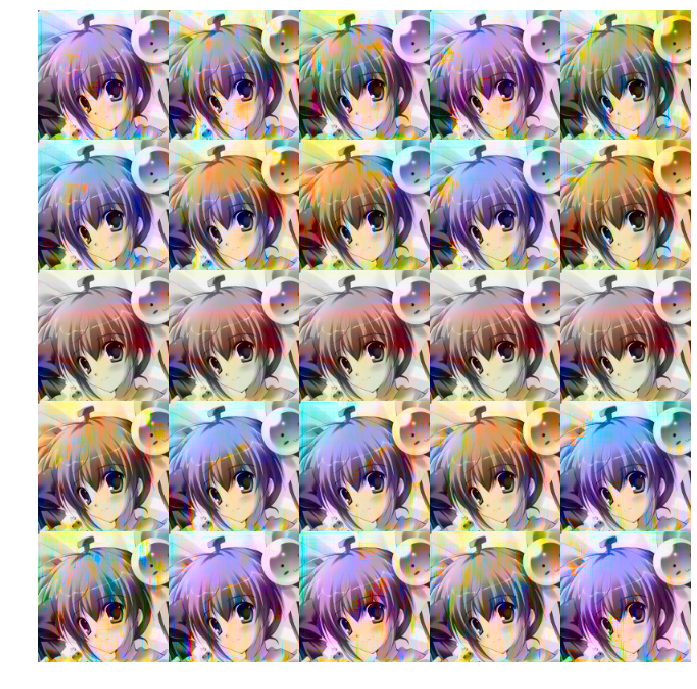

In [25]:
plt.figure(figsize = (12,12))
plt.axis('off')
plt.imshow(lab2rgb(np.concatenate(image_col, axis = 1)*128))
plt.show()

##### Test with different image (same character)

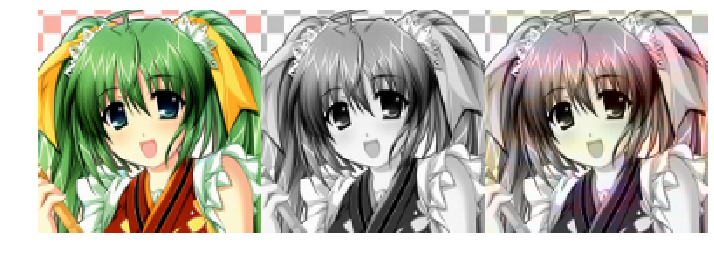

In [26]:
image_valid = plt.imread('directory') # insert name of directory where validation image is located
visualize_validation_image(image_valid, generator, image_size = (size_row, size_col), latent_dim = 1000)

##### Test with Different Character

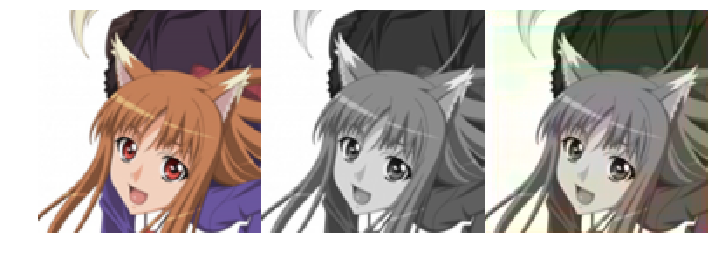

In [27]:
image_valid = plt.imread('directory') # insert name of directory where validation image is located
visualize_validation_image(image_valid, generator, image_size = (size_row, size_col), latent_dim = 1000)